## Face Recognition

In this notebook, we demonstrare the pipeline of face recognition. The objective is to detect faces on images and describe them using the so called embedding vectors. We will use these vectors to estasblish correspondences between different faces and, potentially, find faces belonging to the same person. This is the exact same principle as the feature matching we saw in Lesson 7.

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

### Face Detection

For the sake of completness, we will use the recent YuNet face detector which is included in newer versionf of OpenCV (> 4.7). The YuNet detector is based on convolutional neural networks and the trained weights can be found [here](https://github.com/opencv/opencv_zoo/tree/master/models/face_detection_yunet). Please download them before running this notebook.

In [6]:
# Initialize detector
detector = cv2.FaceDetectorYN.create("./data/face_detection_yunet_2022mar.onnx", "", (320, 320))

# Read image
source = cv2.imread('./data/268.jpg')
source = cv2.cvtColor(source, cv2.COLOR_BGR2RGB)
rows, cols, _ = source.shape

# Get image shape
img_W = int(source.shape[1])
img_H = int(source.shape[0])

# Set input size
detector.setInputSize((cols, rows))

# Run detector
faces_src = detector.detect(source)
assert faces_src[0]

Each row of the detection matrix corresponds to one face. The format of each row is as follows:

 * x1, y1, w, h, x_re, y_re, x_le, y_le, x_nt, y_nt, x_rcm, y_rcm, x_lcm, y_lcm
 
where x1, y1, w, h are the top-left coordinates, width and height of the face bounding box, {x, y}_{re, le, nt, rcm, lcm} stands for the coordinates of right eye, left eye, nose tip, the right corner and left corner of the mouth respectively.

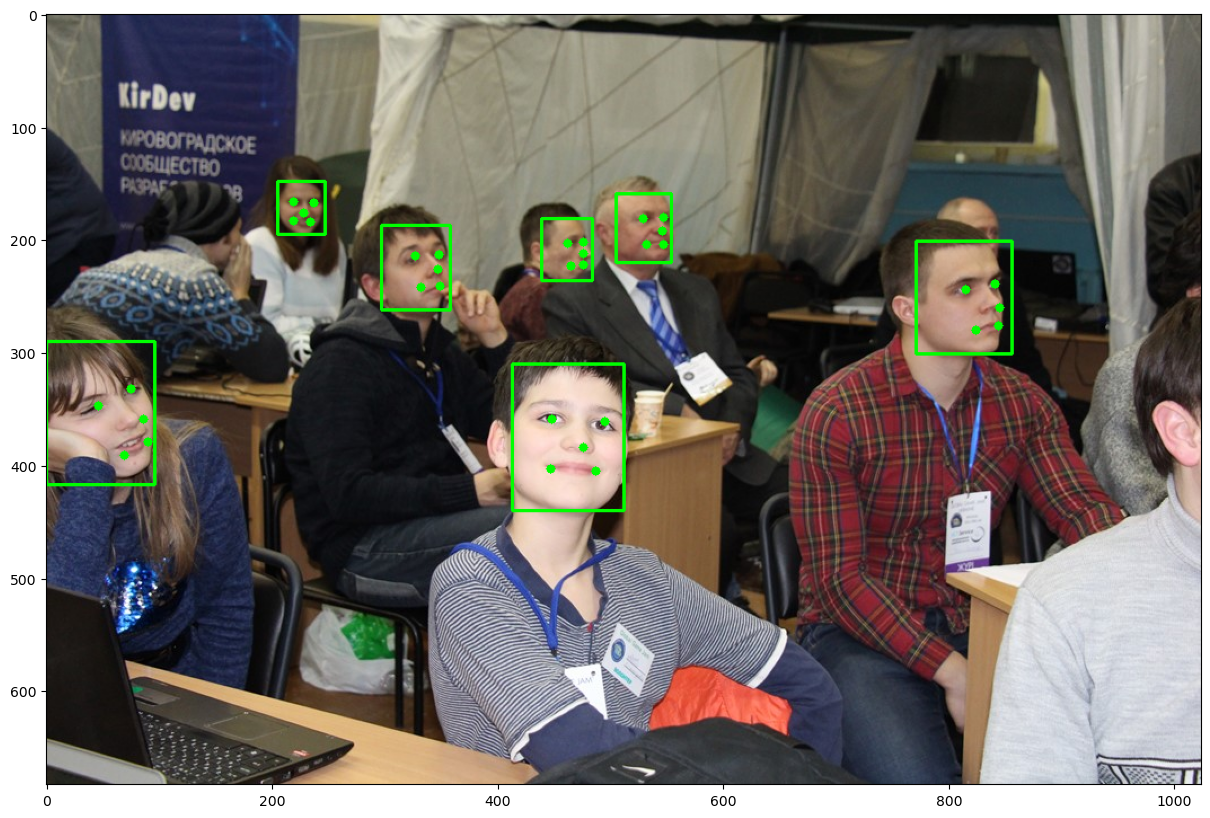

In [7]:
# Show detected faces on image
result = np.copy(source)
faces_src_img = []

for face in faces_src[1]:
    # Draw box
    x1, y1, w, h = face[0:4]
    faces_src_img.append(source[int(y1):int(y1+h), int(x1):int(x1+h), :])
    cv2.rectangle(result, (int(x1), int(y1)), (int(x1+w), int(y1+h)), color=(0, 255, 0), thickness=2)    

    # Draw landmarks
    for idx in range(4, len(face)-1, 2):        
        cv2.circle(result, (int(face[idx]), int(face[idx+1])), radius=4, color=(0, 255, 0), thickness=-1)            

plt.imshow(result)

#### Load Target Image

Let's load a different image on which we want to query the source face.

In [125]:
target = cv2.imread('data/eu_summit.jpg')
target = cv2.cvtColor(target, cv2.COLOR_BGR2RGB)
rows, cols, _ = target.shape

detector.setInputSize((cols, rows))
faces_dst = detector.detect(target)
assert faces_dst[0]

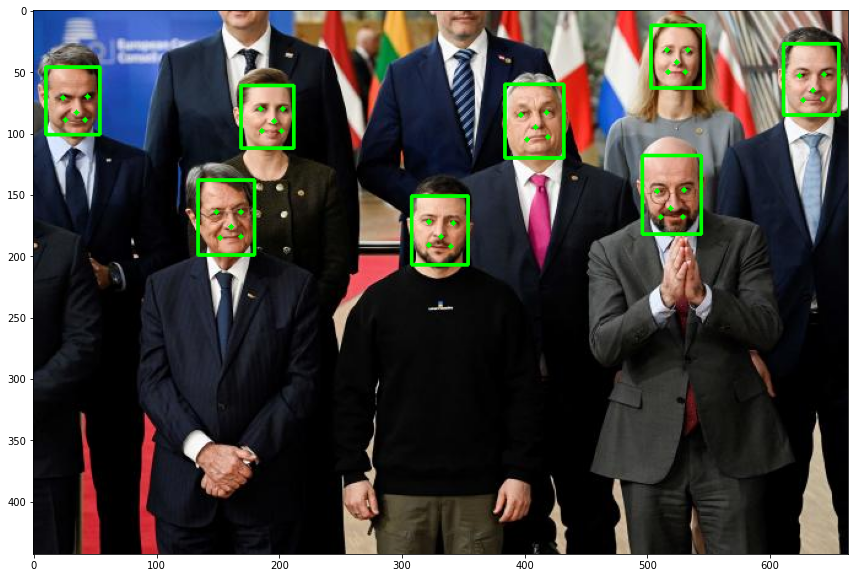

In [138]:
result = np.copy(target)
faces_dst_img = []


for face in faces_dst[1]:    
    x1, y1, w, h = face[0:4]
    faces_dst_img.append(target[int(y1):int(y1+h), int(x1):int(x1+h), :])
    cv2.rectangle(result, (int(x1), int(y1)), (int(x1+w), int(y1+h)), color=(0, 255, 0), thickness=2)
    
    # Draw landmarks
    for idx in range(4, len(face)-1, 2):        
        cv2.circle(result, (int(face[idx]), int(face[idx+1])), radius=2, color=(0, 255, 0), thickness=-1)            
    
plt.imshow(result)

### Face Recognition

Once the face it detected, we need to run the following steps in order to perform a biometric recognition.
 1. Face alignment
 2. Face embeddings
 3. Score evaluation

#### Face Alignment

OpenCV face recognition model offers an elegant way to perform face alignment. In order to run it, we need to download the trained model weights from the official repository ([link](https://github.com/opencv/opencv_zoo/tree/master/models/face_recognition_sface)).

In [112]:
recognizer = cv2.FaceRecognizerSF.create("face_recognition_sface_2021dec.onnx", "")

(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x7f423ce15f40>)

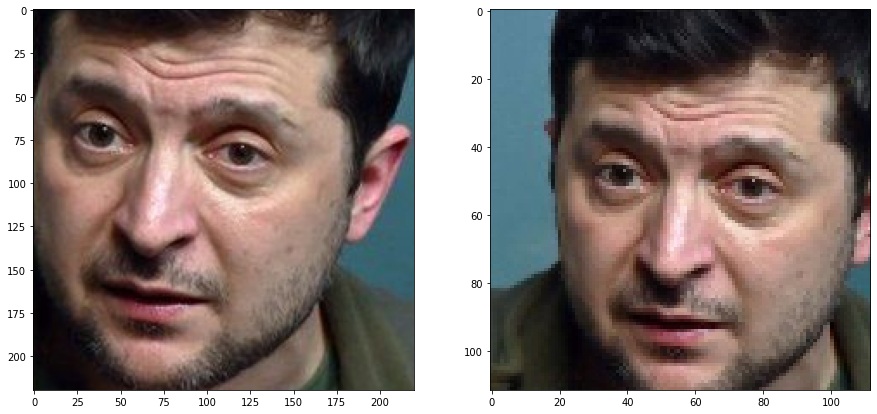

In [132]:
# Align source face
faces_src_agn = recognizer.alignCrop(source, faces_src[1][0])

plt.subplot(121), plt.imshow(faces_src_img[0])
plt.subplot(122), plt.imshow(faces_src_agn)

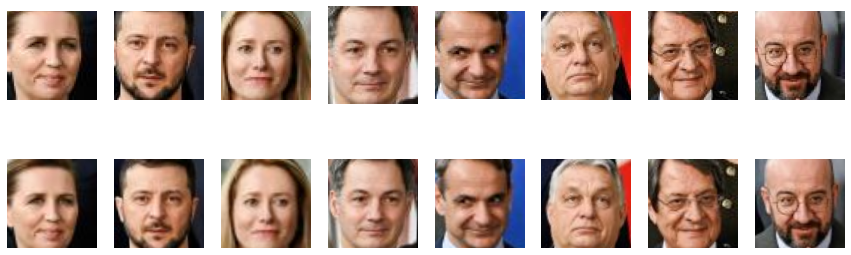

In [143]:
# Align target faces

faces_dst_agn = [recognizer.alignCrop(target, face) for face in faces_dst[1]]

plt.rcParams['figure.figsize'] = [15, 5]
for idx, faces in enumerate(zip(faces_dst_img, faces_dst_agn)):
    plt.subplot(2,8,idx+1), plt.imshow(faces[0]), plt.axis(False)
    plt.subplot(2,8,8+idx+1), plt.imshow(faces[1]), plt.axis(False)

#### Face Embeddings

We will now use the Sigmoid-Constrained Hypersphere Loss for Robust Face Recognition model to extract the face embeddings. The embeddings are conceptually equivalent to keypoint descriptors seen in Lecture 7.

In [150]:
# Extract features
feat_src = recognizer.feature(faces_src_agn)
feats_dst = [recognizer.feature(face) for face in faces_dst_agn]

#### Embedding Matching

After emedding extraction, we need to compute a similarity metric between the source and the candidate faces. There are several options to perform the comparison. The most common metrics are the [L2 norm](https://en.wikipedia.org/wiki/Euclidean_space#Euclidean_norm) and the [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity).

In [161]:
scores = []
for feat_dst in feats_dst:
    score_ = recognizer.match(feat_src, feat_dst, cv2.FaceRecognizerSF_FR_COSINE)
#     score_ = recognizer.match(feat_src, feat_dst, cv2.FaceRecognizerSF_FR_NORM_L2)

    scores.append(score_)

scores

[-0.08063640636248692,
 0.6081716551079808,
 -0.13469246252327594,
 0.0017611576588478783,
 0.15773863699610047,
 0.07246954599577293,
 0.22788226360739827,
 0.11416999785194548]

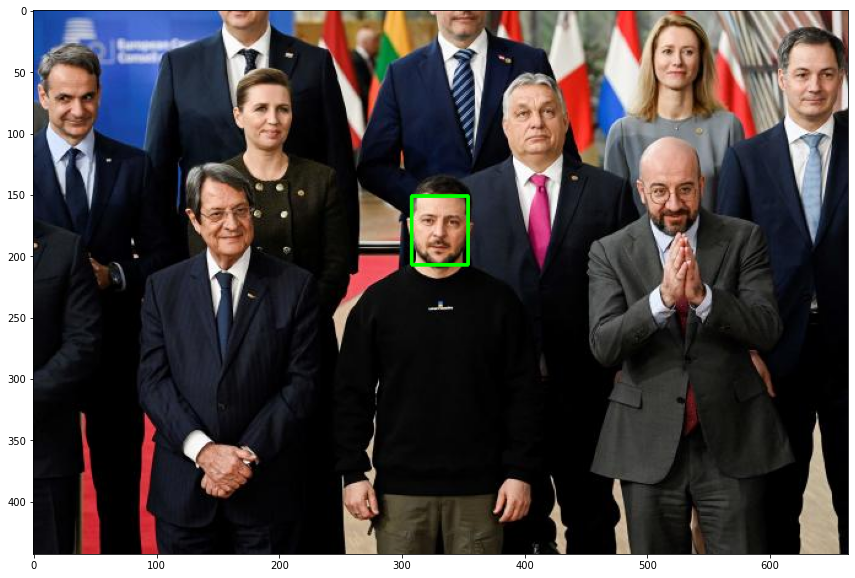

In [160]:
result = np.copy(target)
plt.rcParams['figure.figsize'] = [15, 10]

match = faces_dst[1][np.argmin(scores)]
x1, y1, w, h = match[0:4]
cv2.rectangle(result, (int(x1), int(y1)), (int(x1+w), int(y1+h)), color=(0, 255, 0), thickness=2)
    
plt.imshow(result)